Carrying the same basic concept as notebook 1.


the idea in this notebook involves no prior model, just trying to put a feedforward neural network with reduced state model instead of OpInf. 
More advanced version will not flatten anything and use convolutions.

instead of linear RHS we also put quadratic term. But our quadratic model is very simple Linear tanh scheme for now.

In [1]:
import os
import opinf
import scipy.signal
# import cv2
os.getcwd()

'/home/ajivani/WLROM/WhiteLight'

In [2]:
import numpy as np
from numpy import ogrid
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf as op

In [3]:
import time

In [4]:
from sunpy.visualization import colormaps as cm

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
adjoint=True

In [7]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

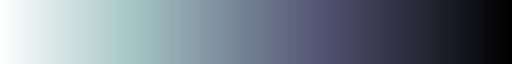

In [9]:
lc3 = cm.cmlist['soholasco3'].reversed()
lc3

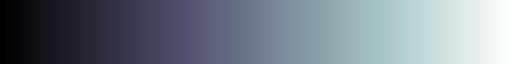

In [10]:
lc3_reg = cm.cmlist['soholasco3']
lc3_reg

In [11]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300,
       # figsize=(9, 3)
       )
plt.rc("font",
       family="serif",
       size=10
       )
plt.rc("legend", edgecolor="none", frameon=True)
plt.rc("text", usetex=False)
# plt.rc("text", usetex=True)

### Setup training and testing data

In [12]:
m = 71

In [13]:
t_vec = (np.linspace(40, 180, m) - 40) / 60
t_vec

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
       0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
       1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ,
       1.33333333, 1.36666667, 1.4       , 1.43333333, 1.46666667,
       1.5       , 1.53333333, 1.56666667, 1.6       , 1.63333333,
       1.66666667, 1.7       , 1.73333333, 1.76666667, 1.8       ,
       1.83333333, 1.86666667, 1.9       , 1.93333333, 1.96666667,
       2.        , 2.03333333, 2.06666667, 2.1       , 2.13333333,
       2.16666667, 2.2       , 2.23333333, 2.26666667, 2.3       ,
       2.33333333])

In [14]:
dt = t_vec[1] - t_vec[0]

In [15]:
nTrainTime = np.argwhere(t_vec == (120 - 40) / 60)[0, 0]

In [16]:
nTrainTime

40

In [17]:
nTrainTimeAll = np.argwhere(np.linspace(2, 180, 90) == 40)[0,0]

In [18]:
t_train = t_vec[:(nTrainTime + 1)]
t_train[-1] * 60 + 40

120.0

In [19]:
t_test = t_vec[(nTrainTime + 1):]
t_test

array([1.36666667, 1.4       , 1.43333333, 1.46666667, 1.5       ,
       1.53333333, 1.56666667, 1.6       , 1.63333333, 1.66666667,
       1.7       , 1.73333333, 1.76666667, 1.8       , 1.83333333,
       1.86666667, 1.9       , 1.93333333, 1.96666667, 2.        ,
       2.03333333, 2.06666667, 2.1       , 2.13333333, 2.16666667,
       2.2       , 2.23333333, 2.26666667, 2.3       , 2.33333333])

In [20]:
X_orig = np.load("./CR2161_tDecay2h_Polar_Compressed.npy")

In [21]:
X = X_orig.reshape((64 * 256, 90, 278))[:, (nTrainTimeAll):, :]

In [22]:
import netCDF4 as nc
ds = nc.Dataset("./20150315_CR2161_code_stable_tDecay2h.nc")
successfulRuns = ds['runs'].successfulRuns + 30
successfulRuns

array([ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110,
       111, 112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 124, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168,
       169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183,
       184, 185, 186, 188, 190, 191, 192, 193, 194, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 22

In [23]:
train_test_sims = np.load("./CR2161_AWSoM2T_CME_tDecay2h_Polar_Clusters.npz")
train_sim = train_test_sims["training_id"]
test_sim = train_test_sims["test_id"]
train_sim, test_sim

(array([  0,   1,   2,   3,   5,   6,   7,   8,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,  30,
         31,  32,  34,  35,  36,  37,  38,  39,  41,  42,  44,  45,  48,
         49,  50,  51,  52,  54,  55,  56,  57,  58,  59,  61,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  77,  78,
         79,  82,  84,  85,  86,  87,  88,  90,  91,  92,  93,  94,  95,
         96,  98, 100, 102, 103, 104, 105, 106, 107, 108, 110, 113, 114,
        115, 116, 118, 120, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 138, 139, 140, 142, 143, 146, 147, 148,
        149, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        165, 166, 167, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 194, 196, 197,
        198, 199, 200, 201, 202, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 216, 217, 219, 220, 221, 222, 223

In [24]:
tt_sim = np.sort(np.hstack((train_sim, test_sim)))

In [25]:
X_train_ttrain = X[:, :(nTrainTime + 1), train_sim]
X_train_ttrain.shape

(16384, 41, 222)

In [26]:
X_test = X[:, :, test_sim]

In [27]:
X_train_test_ttrain = X[:, :(nTrainTime + 1), :]

In [28]:
X_train_ttrain.shape

(16384, 41, 222)

In [29]:
rom_1 = op.ContinuousOpInfROM(modelform="AH")
basis_1 = op.pre.PODBasis().fit(X_train_ttrain[:, :, 0], residual_energy=1e-8)
basis_1.r

32

In [30]:
reduced_states = basis_1.encode(X_train_ttrain[:, :, 0])

In [31]:
reduced_states.shape

(32, 41)

In [32]:
reduced_states[1, :]

array([ 5.18753867,  5.4877632 ,  5.74297088,  5.93984572,  6.07472786,
        6.14135307,  6.13742178,  6.06361853,  5.92100359,  5.70977877,
        5.42965491,  5.08355595,  4.67775802,  4.21922311,  3.71461306,
        3.16796246,  2.58665005,  1.98280391,  1.36212992,  0.73077039,
        0.09351159, -0.54198027, -1.16760093, -1.77649704, -2.36307699,
       -2.92112476, -3.44261899, -3.92287053, -4.35932236, -4.74802847,
       -5.08321308, -5.36596717, -5.59438547, -5.76788039, -5.88884099,
       -5.95946237, -5.98421062, -5.96423347, -5.90416973, -5.80922226,
       -5.68420387])

### Construction of NODE Architecture

In [33]:
device

device(type='cuda', index=0)

In [34]:
t_train

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
       0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
       1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ,
       1.33333333])

In [35]:
data_size = t_train.shape[0]
batch_time = 5
batch_size = 10
print("Data size = ", data_size, " Batch time = ", batch_time, " Batch size = ", batch_size)

Data size =  41  Batch time =  5  Batch size =  10


In [36]:
t = torch.tensor(np.float32(t_train)).to(device)

In [37]:
t.dtype

torch.float32

In [38]:
true_y0 = torch.from_numpy(np.float32(reduced_states[:, 0]))
true_y0 = true_y0.reshape((1, len(true_y0))).to(device)
true_y0.shape

torch.Size([1, 32])

In [39]:
true_y0.dtype

torch.float32

In [40]:
reduced_states.shape

(32, 41)

In [41]:
yreduced = np.float32(reduced_states.T)
true_y = torch.from_numpy(np.expand_dims(yreduced, axis=1)).to(device)
true_y.shape

torch.Size([41, 1, 32])

In [42]:
true_y.dtype

torch.float32

Need functions for getting batch, getting true x, getting ODE func - where we run the "loss" metric compared to the true simulation.

The batch is taking IC as values at different times in the training set, and the solution as the values following the IC upto some predefined batch size for time.

In [43]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64),
                                          batch_size, replace=False))
    batch_y0 = true_y[s]
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [44]:
by0, bt, by = get_batch()

In [45]:
batch_time

5

In [46]:
by0.shape, bt.shape, by.shape

(torch.Size([10, 1, 32]), torch.Size([5]), torch.Size([5, 10, 1, 32]))

In [47]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [48]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(32, 50),
            nn.Tanh(),
            nn.Linear(50, 32),
        )
        
        self.net2 = nn.Sequential(
            nn.Linear(528, 32),
            nn.Tanh(),
        )

        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
                
        for m in self.net2.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    
    def quadratic_y(self, y):
        y_np = torch.squeeze(y, axis=1)
        y_np_quad = torch.zeros((y_np.shape[0], 1, int(y_np.shape[1] * (y_np.shape[1] + 1)/2)))
        
#         y_np = np.squeeze(y.cpu().detach().numpy(), axis=1)
#         y_np_quad = np.zeros((y_np.shape[0], int(y_np.shape[1] * (y_np.shape[1] + 1)/2)))
        for i in range(y_np.shape[0]):
#             y_np_quad[i, :] = np.outer(y_np[i, :], y_np[i, :])[np.tril_indices(y_np.shape[1])]
            y_np_quad[i, 0, :] = torch.outer(y_np[i, :], y_np[i, :])[np.tril_indices(y_np.shape[1])]
            
#         y_t_quad = torch.from_numpy(np.expand_dims(np.float32(y_np_quad), axis=1)).to(device)

#         return y_t_quad
        return y_np_quad.to(device)
            
    def forward(self, t, y):
            return self.net1(y) + self.net2(self.quadratic_y(y))

In [55]:
ii = 0
func = ODEFunc().to(device)
# optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

In [56]:
niters = 4000
test_freq = 5

In [57]:
func

ODEFunc(
  (net1): Sequential(
    (0): Linear(in_features=32, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=32, bias=True)
  )
  (net2): Sequential(
    (0): Linear(in_features=528, out_features=32, bias=True)
    (1): Tanh()
  )
)

In [58]:
func(t, by0)

tensor([[[-0.9486, -0.9770,  0.8107, -1.4536,  0.3347, -1.4788, -1.4151,
          -1.1777,  1.3249, -1.3134, -1.7252,  0.4984, -0.9349, -1.3901,
          -0.7976,  0.9198, -0.9457, -1.9621,  1.3927,  1.0159,  1.0512,
           0.7919, -1.7283,  0.9869,  0.2291,  0.8672, -0.5542,  2.3375,
           0.4862,  0.8731, -1.8511,  1.0559]],

        [[-0.9564, -0.9870,  1.0130, -1.4195,  0.3856, -1.5812, -1.2758,
          -1.0547,  1.2974, -1.3962, -1.5318,  0.4250, -0.8742, -1.2951,
          -0.6596,  0.8638, -1.0100, -1.9507,  1.3994,  0.7276,  0.9501,
           0.7913, -1.8294,  0.9275,  0.3481,  0.6983, -0.6768,  2.3047,
           0.4808,  0.8467, -1.8076,  0.9912]],

        [[-0.9646, -0.9726,  1.0374, -1.4129,  0.3825, -1.5728, -1.2425,
          -1.0596,  1.2714, -1.4058, -1.5003,  0.4315, -0.8628, -1.2608,
          -0.6691,  0.8447, -1.0133, -1.9613,  1.4017,  0.6897,  0.9325,
           0.7970, -1.8521,  0.9309,  0.3644,  0.6780, -0.6930,  2.3158,
           0.4747,  0.8441

In [60]:
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

step_loss = []
for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    step_loss.append(loss.item())
    
    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
#             visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()

Iter 0005 | Total Loss 1.105037
Iter 0010 | Total Loss 0.994817
Iter 0015 | Total Loss 0.902270
Iter 0020 | Total Loss 0.828587
Iter 0025 | Total Loss 0.768077
Iter 0030 | Total Loss 0.715300
Iter 0035 | Total Loss 0.670959
Iter 0040 | Total Loss 0.613524
Iter 0045 | Total Loss 0.594399
Iter 0050 | Total Loss 0.579634
Iter 0055 | Total Loss 0.564070
Iter 0060 | Total Loss 0.552658
Iter 0065 | Total Loss 0.545414
Iter 0070 | Total Loss 0.539397
Iter 0075 | Total Loss 0.530611
Iter 0080 | Total Loss 0.523284
Iter 0085 | Total Loss 0.515635
Iter 0090 | Total Loss 0.502393
Iter 0095 | Total Loss 0.496562
Iter 0100 | Total Loss 0.485850
Iter 0105 | Total Loss 0.481865
Iter 0110 | Total Loss 0.471378
Iter 0115 | Total Loss 0.454479
Iter 0120 | Total Loss 0.449235
Iter 0125 | Total Loss 0.446015
Iter 0130 | Total Loss 0.449729
Iter 0135 | Total Loss 0.444307
Iter 0140 | Total Loss 0.438297
Iter 0145 | Total Loss 0.429040
Iter 0150 | Total Loss 0.419837
Iter 0155 | Total Loss 0.414900
Iter 016

Iter 1290 | Total Loss 0.297314
Iter 1295 | Total Loss 0.301858
Iter 1300 | Total Loss 0.304148
Iter 1305 | Total Loss 0.294874
Iter 1310 | Total Loss 0.302620
Iter 1315 | Total Loss 0.305468
Iter 1320 | Total Loss 0.296494
Iter 1325 | Total Loss 0.294618
Iter 1330 | Total Loss 0.287583
Iter 1335 | Total Loss 0.286231
Iter 1340 | Total Loss 0.285343
Iter 1345 | Total Loss 0.280488
Iter 1350 | Total Loss 0.274927
Iter 1355 | Total Loss 0.280978
Iter 1360 | Total Loss 0.284135
Iter 1365 | Total Loss 0.276942
Iter 1370 | Total Loss 0.273533
Iter 1375 | Total Loss 0.275374
Iter 1380 | Total Loss 0.272267
Iter 1385 | Total Loss 0.261393
Iter 1390 | Total Loss 0.257766
Iter 1395 | Total Loss 0.262680
Iter 1400 | Total Loss 0.261522
Iter 1405 | Total Loss 0.261362
Iter 1410 | Total Loss 0.258123
Iter 1415 | Total Loss 0.262157
Iter 1420 | Total Loss 0.265262
Iter 1425 | Total Loss 0.262939
Iter 1430 | Total Loss 0.251671
Iter 1435 | Total Loss 0.256183
Iter 1440 | Total Loss 0.263567
Iter 144

Iter 2575 | Total Loss 0.148660
Iter 2580 | Total Loss 0.148822
Iter 2585 | Total Loss 0.147865
Iter 2590 | Total Loss 0.148427
Iter 2595 | Total Loss 0.150158
Iter 2600 | Total Loss 0.154721
Iter 2605 | Total Loss 0.157548
Iter 2610 | Total Loss 0.165447
Iter 2615 | Total Loss 0.163401
Iter 2620 | Total Loss 0.160078
Iter 2625 | Total Loss 0.160951
Iter 2630 | Total Loss 0.155481
Iter 2635 | Total Loss 0.159262
Iter 2640 | Total Loss 0.149665
Iter 2645 | Total Loss 0.150608
Iter 2650 | Total Loss 0.152380
Iter 2655 | Total Loss 0.146110
Iter 2660 | Total Loss 0.156877
Iter 2665 | Total Loss 0.148191
Iter 2670 | Total Loss 0.154740
Iter 2675 | Total Loss 0.154172
Iter 2680 | Total Loss 0.142939
Iter 2685 | Total Loss 0.147358
Iter 2690 | Total Loss 0.148212
Iter 2695 | Total Loss 0.141022
Iter 2700 | Total Loss 0.145571
Iter 2705 | Total Loss 0.145431
Iter 2710 | Total Loss 0.150453
Iter 2715 | Total Loss 0.151030
Iter 2720 | Total Loss 0.149836
Iter 2725 | Total Loss 0.144229
Iter 273

Iter 3860 | Total Loss 0.129780
Iter 3865 | Total Loss 0.131493
Iter 3870 | Total Loss 0.129516
Iter 3875 | Total Loss 0.124902
Iter 3880 | Total Loss 0.127349
Iter 3885 | Total Loss 0.131779
Iter 3890 | Total Loss 0.130238
Iter 3895 | Total Loss 0.136015
Iter 3900 | Total Loss 0.134108
Iter 3905 | Total Loss 0.132300
Iter 3910 | Total Loss 0.130651
Iter 3915 | Total Loss 0.131663
Iter 3920 | Total Loss 0.128599
Iter 3925 | Total Loss 0.129159
Iter 3930 | Total Loss 0.128141
Iter 3935 | Total Loss 0.128532
Iter 3940 | Total Loss 0.123429
Iter 3945 | Total Loss 0.120236
Iter 3950 | Total Loss 0.129861
Iter 3955 | Total Loss 0.120188
Iter 3960 | Total Loss 0.118672
Iter 3965 | Total Loss 0.121619
Iter 3970 | Total Loss 0.122321
Iter 3975 | Total Loss 0.119559
Iter 3980 | Total Loss 0.121728
Iter 3985 | Total Loss 0.122225
Iter 3990 | Total Loss 0.126067
Iter 3995 | Total Loss 0.124902
Iter 4000 | Total Loss 0.120137


In [76]:
# torch.save(func.state_dict(), "dydt_Ay_Hyy_4000_steps.pt")

**good point**: is it even a good idea to train two nets simultaneously by just taking naive sum of predictions and plugging into loss? see responses on: https://stackoverflow.com/questions/67872719/is-it-possible-to-combine-2-neural-networks

Effectively, we have two things to check over here:

1. What is the error within the training set, if we provide initial condition y0?

2. What is the error on the held out part of the data with the same IC?

We could just plot the 2D images and check this qualitatively / with RMSE, with the caveat that RMSE is not really the metric we want to be optimizing for. Also is evaluating error between reduced _as opposed to_ full state appropriate?

If we tried everything with train times in first sim  i.e. `true_y` was derived from reduced states constructed off `X_train_ttrain[:, :, 0]` then `X_train_ttrain[:, :, 0]` is basically decoded shape for the `true_y`.

Predicted `y` i.e. `pred_y` needs to be decoded.

In [61]:
with torch.no_grad():
    pred_y = odeint(func, true_y0, t)

In [62]:
pred_y.shape

torch.Size([41, 1, 32])

In [63]:
pred_y_np = pred_y.cpu().numpy()[:, 0, :].T

In [64]:
pred_y_decoded = basis_1.decode(pred_y_np)

In [65]:
true_y_decoded = X_train_ttrain[:, :, 0]

In [66]:
pred_y_decoded.shape

(16384, 41)

visualization for if we are able to replicate training properly.

In [67]:
64 * 256

16384

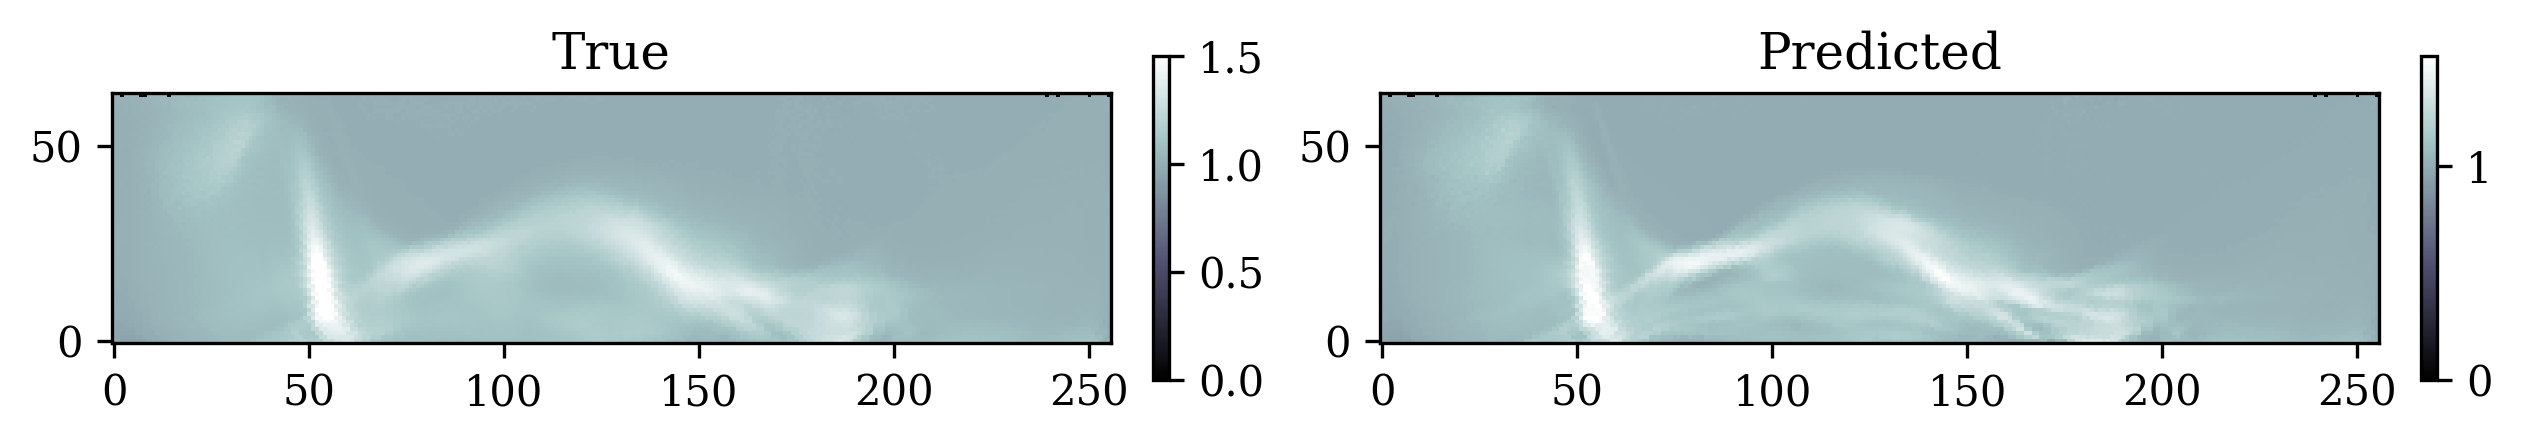

In [68]:
# def visualize():
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
axs = ax.ravel()
im0 = axs[0].imshow(true_y_decoded[:, 40].reshape(64, 256),
            origin="lower",
            cmap=lc3_reg)
axs[0].set_title("True")
fig.colorbar(im0, fraction=0.046 * 1/3, pad=0.04)

im1 = axs[1].imshow(pred_y_decoded[:, 40].reshape(64, 256),
                   origin="lower",
                   cmap=lc3_reg)
axs[1].set_title("Predicted")
fig.colorbar(im1, fraction=0.046 * 1/3, pad=0.04)

by comparison to notebook 1?



testing times comparison to notebook 1?

In [69]:
t_full = torch.tensor(np.float32(t_vec)).to(device)

In [70]:
with torch.no_grad():
    pred_y_train_sim_fullt = odeint(func, true_y0, t_full)

In [71]:
pred_y_train_sim_fullt_decoded = basis_1.decode(pred_y_train_sim_fullt.cpu().numpy()[:, 0, :].T)

In [72]:
pred_y_train_sim_fullt_decoded.shape

(16384, 71)

In [73]:
true_y_decoded_fullt = X[:, :, 0]
true_y_decoded_fullt.shape

(16384, 71)

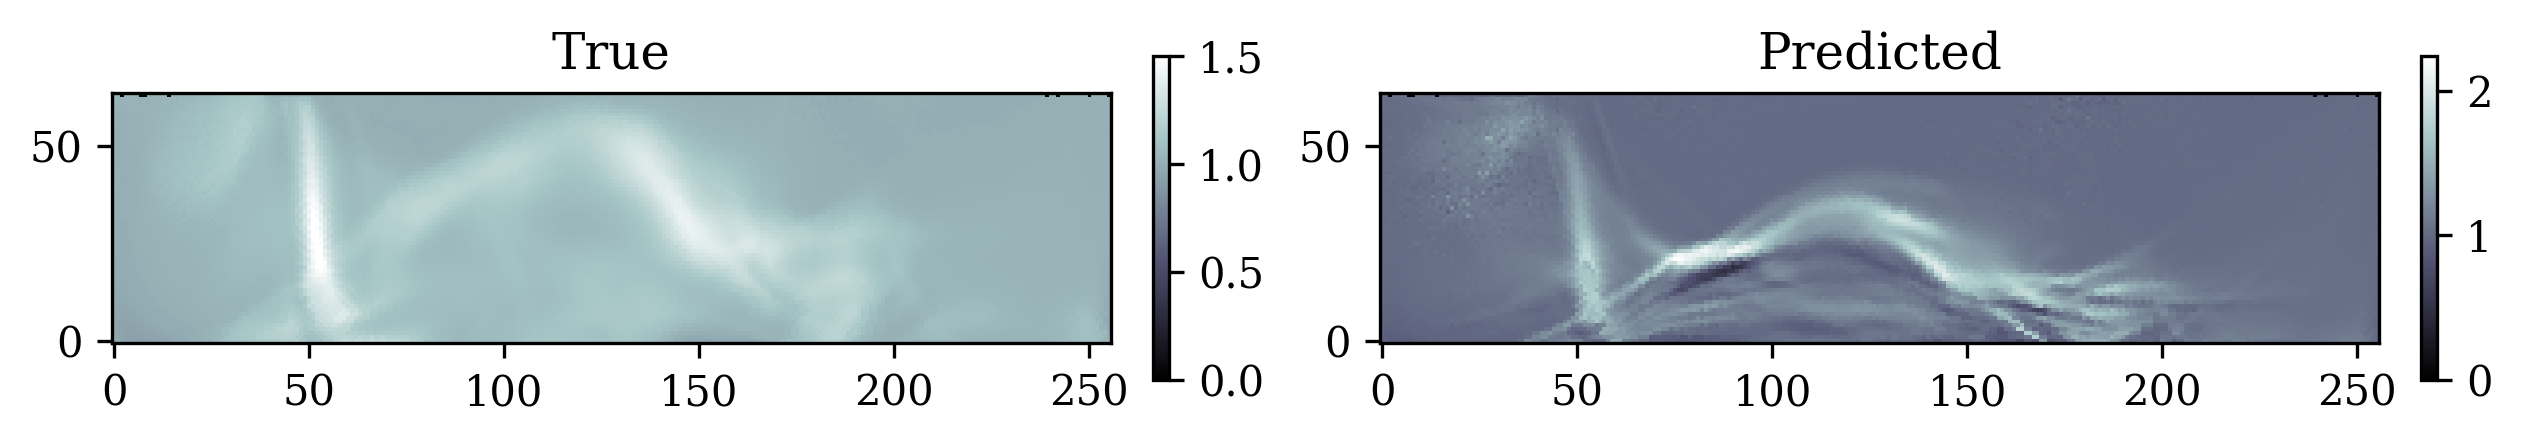

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
axs = ax.ravel()
im0 = axs[0].imshow(true_y_decoded_fullt[:, 70].reshape(64, 256),
            origin="lower",
            cmap=lc3_reg)
axs[0].set_title("True")
fig.colorbar(im0, fraction=0.046 * 1/3, pad=0.04)

im1 = axs[1].imshow(pred_y_train_sim_fullt_decoded[:, 70].reshape(64, 256),
                   origin="lower",
                   cmap=lc3_reg)
axs[1].set_title("Predicted")
fig.colorbar(im1, fraction=0.046 * 1/3, pad=0.04)

Try the same example but with prior learnt OpInf model.

#### Scratch Start

In [ ]:
32 * (32 + 1) / 2

In [ ]:
np.outer([1, 2, 3, 4], [2, 3, 4, 5])

In [ ]:
np.tril_indices(4)

In [ ]:
v_out_flat = np.outer([1, 2, 3, 4], [2, 3, 4, 5])[np.tril_indices(4)]
v_out_flat

In [ ]:
torch.tensor(v_out_flat)

In [ ]:
vquad_t = torch.from_numpy(np.float32(v_out_flat)).reshape((1, len(v_out_flat))).to(device)

In [ ]:
v_np = vquad_t.cpu().numpy().flatten()

In [ ]:
v_np

In [ ]:
# test bed for getting quadratic term in neural net implemented
aaa = np.array([[[1, 2, 3]],
               [[10, 11, 12]]
               ])
aaa


aaa[0, :, :]


sq = np.squeeze(aaa, axis=1)

def qy3(y):
    y_np = np.squeeze(y, axis=1)
    y_np_quad = np.zeros((y_np.shape[0], int(y_np.shape[1] * (y_np.shape[1] + 1)/2)))
    for i in range(y_np.shape[0]):
        y_np_quad[i, :] = np.outer(y_np[i, :], y_np[i, :])[np.tril_indices(y_np.shape[1])]

    y_t_quad = torch.from_numpy(np.expand_dims(np.float32(y_np_quad), axis=1)).to(device)

    return y_t_quad

qy3(aaa)

aaat = qy3(aaa)
aaat.shape

#### Scratch End